# Plot scan

In [7]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
from auxPlots import interpolateData,getContours,saveContours,readContours
pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

### Load monojet results

In [8]:
# Mono-Jet (CMS-EXO-20-004)
monojetDF = pd.read_pickle('../../Recast/CMS-EXO-20-004_monojet/pp2STST_monojet.pcl')

### Load SModelS results

In [9]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('../../Recast/sms_smodels.pcl')
# print(dataDF.columns.values.tolist()) #Print all columns names

#### Set r = 0 for points with no results 

In [10]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

### Define k-factor

In [11]:
kfactor=1.5

#### Define exclusions

In [12]:
#Add simple flag for excluded points:
newDF = dataDF.copy()
newDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1/kfactor

#### Add c*tau and deltaM columns

In [13]:
newDF['ctau.5000002'] = 1.967e-16/dataDF['width.5000002']
newDF['deltaM'] = dataDF['mass.5000002']-dataDF['mass.5000012']

monojetDF['deltaM'] = monojetDF['$m_{\tilde t}$'] - monojetDF['$m_{\tilde \chi_1^0}$']

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_5215/185707070.py:4: SyntaxWarning: invalid escape sequence '\c'
  monojetDF['deltaM'] = monojetDF['$m_{\tilde t}$'] - monojetDF['$m_{\tilde \chi_1^0}$']


### Get points excluded:

In [14]:
dataDF = newDF
excluded = dataDF[dataDF['excludedLHC'] == True]
allowed = dataDF[(dataDF['excludedLHC'] == False)]

print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 207
Total excluded (LHC) = 72
Total allowed = 135



### Split data frame by analyis/txname

In [15]:
allAnas = []
allTx = []
useDF = dataDF
anaIDcols = [c for c in useDF.columns if '.AnalysisID' in c]
txIDcols = [c for c in useDF.columns if '.TxNames' in c]
for c in anaIDcols:
    allAnas += useDF[c].values.tolist()
for c in txIDcols:
    allTx += useDF[c].values.tolist()

allAnas = [a for a in allAnas if isinstance(a,str)]
allAnas = sorted(list(set(allAnas)))
allTx = [tuple(a) for a in allTx if isinstance(a,list)]
allTx = sorted(list(set(allTx)))
anaDFs = {}
for a in allAnas:
    anaDFs[a] = {}
    newrowList = []
    for irow,row in useDF.iterrows():
        ires = [col for col in anaIDcols if (row[col] == a)]
        if not ires:
            continue
        ires = ires[0]
        ires = ires.rsplit('.',1)[0]
        newrow = { }
        for c in dataDF.columns:
            if not 'ExptRes.result' in c:
                newrow[c] = row[c]
            elif c.rsplit('.',1)[0] == ires:
                newrow[c.replace(ires,'ExptRes.result')] = row[c]
        newrowList.append(newrow)
    if len(newrowList) != 0:
        anaDFs[a] = pd.DataFrame.from_dict(newrowList)

### Get contours from SModelS

In [16]:
contoursDictAna = {}
for ana in anaDFs:
    anaDF = anaDFs[ana]
    if len(anaDF[anaDF['ExptRes.result.r'] > 1.0/kfactor]) == 0:
        continue
    x = anaDF['mass.5000002']
    dm = anaDF['deltaM']
    z = anaDF['ExptRes.result.r']
    xnew,ynew,znew = interpolateData(x,dm,z,fill_value=np.nan)
    if xnew is None:
        continue
    # Get contours
    cValues = sorted([1.,float('%1.2f'%(1./kfactor))])
    cList = getContours(xnew,ynew,znew,cValues)[float('%1.2f'%(1./kfactor))]
    if len(cList) > 0:
        contoursDictAna[ana] = cList


### Get contours from MonoJet

In [17]:
anaDF = monojetDF
x = anaDF['$m_{\tilde t}$']
dm = anaDF['deltaM']
z = 1./anaDF['$\mu^{UL}_{obs}$']
xnew,ynew,znew = interpolateData(x,dm,z,fill_value=np.nan)
# Get contours
cValues = sorted([1.,float('%1.2f'%(1./kfactor))])
cList = getContours(xnew,ynew,znew,cValues)[float('%1.2f'%(1./kfactor))]
if len(cList) > 0:
    contoursDictAna['CMS-EXO-20-004'] = cList

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_5215/3746443335.py:4: SyntaxWarning: invalid escape sequence '\m'
  z = 1./anaDF['$\mu^{UL}_{obs}$']


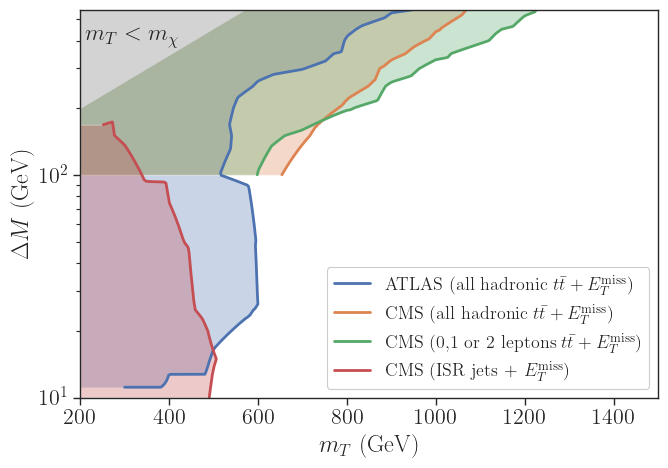

In [18]:
plt.figure(figsize=(7,5))
labelsDict = {'CMS-SUS-20-002' : r'CMS-SUS-20-002 (0,1 or 2 leptons $t \bar{t} + E_{T}^{\rm miss}$)',
              'CMS-SUS-19-006-agg' : r'CMS-SUS-19-006 (all hadronic $t \bar{t} + E_{T}^{\rm miss}$)',
              'ATLAS-SUSY-2018-12' : r'ATLAS-SUSY-2018-12 (all hadronic $t \bar{t} + E_{T}^{\rm miss}$)'}

labelsDict = {'CMS-SUS-20-002' : r'CMS (0,1 or 2 leptons $t \bar{t} + E_{T}^{\rm miss}$)',
              'CMS-SUS-19-006-agg' : r'CMS (all hadronic $t \bar{t} + E_{T}^{\rm miss}$)',
              'ATLAS-SUSY-2018-12' : r'ATLAS (all hadronic $t \bar{t} + E_{T}^{\rm miss}$)',
              'CMS-EXO-20-004' : r'CMS (ISR jets + $ E_{T}^{\rm miss}$)'}

for ana,c in contoursDictAna.items():
    if ana not in ['CMS-SUS-20-002','CMS-SUS-19-006-agg', 
                   'ATLAS-SUSY-2018-12', 'CMS-EXO-20-004']:
        continue
    x = c[:,0]
    y = c[:,1]
    plt.plot(x,y,label=labelsDict[ana],linewidth=2)
    plt.fill_betweenx(y,x,200,alpha=0.3)



# x = monoJetDict[0.66]['mST_GeV']
# y = monoJetDict[0.66]['deltaM_GeV']
# plt.plot(x,y,label=labelsDict['CMS-EXO-20-004'],linewidth=2)
# plt.fill_betweenx(y,x,200,alpha=0.3)

plt.fill_betweenx([200.,600.],[200.,600.],color='lightgray',alpha=1.0)
plt.text(210.,400.,r'$m_T < m_{\chi}$',fontsize=17)
plt.legend(loc='lower right',fontsize=13,framealpha=1.0)
plt.yscale('log')
plt.xlabel(r'$m_T$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
plt.ylim(10.,550.)
plt.xlim(200.,1500.)
plt.tight_layout()
plt.savefig('directSearches.png')
plt.show()

In [19]:
# Interpolate to create more points from SModelS scan:
x = dataDF['mass.5000002']
dm = dataDF['deltaM']
z = dataDF['ExptRes.result0.r']
xnew,ynew,znew = interpolateData(x,dm,z,fill_value=np.nan)

# Interpolate for the same points using the MonoJet scan:
xMJ = monojetDF['$m_{\tilde t}$']
dmMJ = xMJ-monojetDF['$m_{\tilde \chi_1^0}$']
zMJ = 1./monojetDF['$\mu^{UL}_{obs}$']
xnewMJ,ynewMJ,znewMJ = interpolateData(xMJ,dmMJ,zMJ,xnew=xnew[:,0],ynew=ynew[0,:],fill_value=np.nan)

# Use the maximum zvalue (for the points where a MonoJet result exists)
znewMax = znew.copy()
np.maximum(znew,znewMJ,where=(~np.isnan(znewMJ)),
           out=znewMax)
znew=znewMax
# # Get contours
cValues = sorted([1.,0.66])
contoursDict = getContours(xnew,ynew,znew,cValues)

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:10: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_5215/3965146760.py:9: SyntaxWarning: invalid escape sequence '\c'
  dmMJ = xMJ-monojetDF['$m_{\tilde \chi_1^0}$']
/tmp/ipykernel_5215/3965146760.py:10: SyntaxWarning: invalid escape sequence '\m'
  zMJ = 1./monojetDF['$\mu^{UL}_{obs}$']


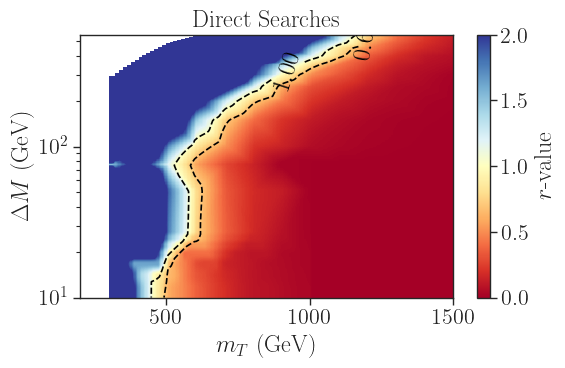

In [20]:
plt.figure(figsize=(6,4))
plt.imshow(znew.T, extent=[x.min(),x.max(), dm.min(), dm.max()], origin='lower',
                  cmap=cm,aspect='auto',vmin=0,vmax=2)
plt.colorbar(label=r'$r$-value')
plt.xlabel(r'$m_{T}$ (GeV)')
plt.ylabel(r'$\Delta M$ (GeV)')
contours = plt.contour(xnew, ynew, znew, cValues, colors='black',linestyles='dashed')
plt.clabel(contours, inline=True, fontsize=18)
# plt.yscale('log')
plt.title('Direct Searches')
plt.yscale('log')
# plt.ylim(10.,500.)
plt.xlim(200,1500)
plt.tight_layout()
plt.show()

### Save contour curves to text files

In [21]:
fname = 'DirectSearches_contours.csv'
saveContours(contoursDict,fname,header='mST_GeV,deltaM_GeV')


Contours saved to DirectSearches_contours.csv
